<a href="https://colab.research.google.com/github/Leanse1/Atmospheric-Cloud-Image-Classification/blob/main/Atmospheric_Cloud_Classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/CADDPD

# 1. Data Cleaning + preprocessing

In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset = '/content/drive/MyDrive/Cloud_Dataset'

# Create a dataset from the directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2543 files belonging to 11 classes.


In [5]:
class_names = dataset.class_names
class_names

['AltoCumulus',
 'AltoStratus',
 'CirroCumulus',
 'CirroStratus',
 'Cirrus',
 'Contrail',
 'CumuloNimbus',
 'Cumulus',
 'NimboStratus',
 'StratoCumulus',
 'Stratus']

In [6]:
for image, label in dataset.take(1):
    print(image.shape)
    print(label.numpy())

(32, 256, 256, 3)
[ 6  5  9  7  9  5  2  7  8  8  6  6  6  0  7  8  9  1  9  3 10  3  9  2
  5  4  5  1  2  1  2  0]


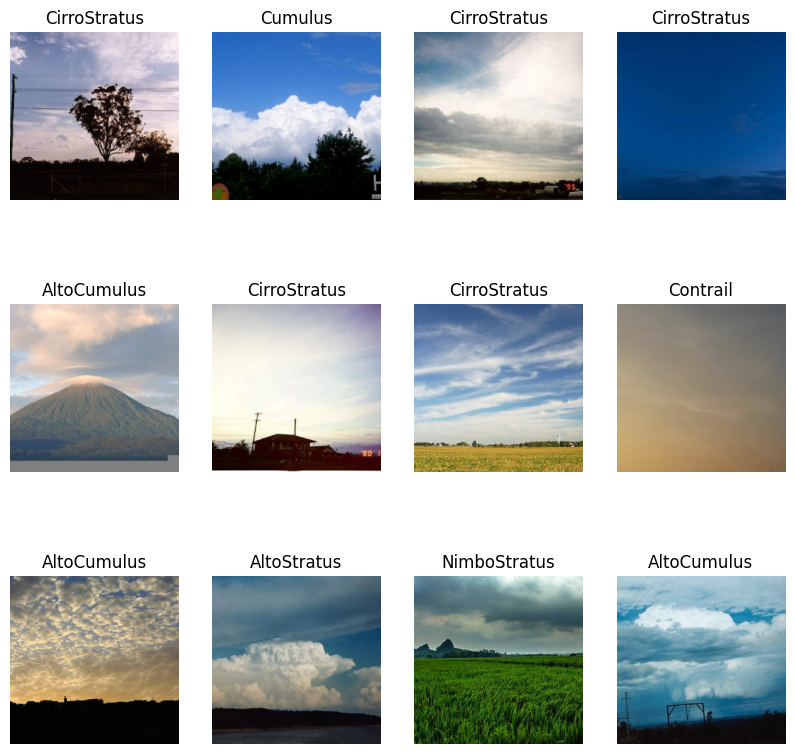

In [7]:
plt.figure(figsize=(10, 10))
import matplotlib.pyplot as plt

# Assuming you have a list of class names defined as class_names

for images, labels in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)

    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [11]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255), # It divides each pixel to a normalized range between 0 and 1.
])

# 2. Data Augmentation

In [12]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


In [13]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# 3. Building a Model

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 11

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)


In [16]:
model.compile(
    optimizer='adam',
    # from_logits=False, I am indicating model's output is expected to be probabilities,
    #and the cross-entropy loss will be computed based on these probabilities.
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=300,
    callbacks=[early_stopping]
)

Epoch 1/300
64/64 [==============================] - 19s 299ms/step - loss: 0.8459 - accuracy: 0.6929 - val_loss: 1.0976 - val_accuracy: 0.6484
Epoch 2/300
64/64 [==============================] - 18s 277ms/step - loss: 0.8252 - accuracy: 0.6865 - val_loss: 1.0042 - val_accuracy: 0.6719
Epoch 3/300
64/64 [==============================] - 19s 290ms/step - loss: 0.8032 - accuracy: 0.7129 - val_loss: 1.0990 - val_accuracy: 0.6484
Epoch 4/300
64/64 [==============================] - 18s 276ms/step - loss: 0.8384 - accuracy: 0.6885 - val_loss: 1.0454 - val_accuracy: 0.6211
Epoch 5/300
64/64 [==============================] - 19s 302ms/step - loss: 0.8202 - accuracy: 0.6958 - val_loss: 1.0902 - val_accuracy: 0.6055
Epoch 6/300
64/64 [==============================] - 18s 281ms/step - loss: 0.7682 - accuracy: 0.7163 - val_loss: 1.0319 - val_accuracy: 0.6602
Epoch 7/300
64/64 [==============================] - 18s 288ms/step - loss: 0.8155 - accuracy: 0.7026 - val_loss: 1.1244 - val_accuracy:

# On Test Data set

In [29]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 0s 28ms/step - loss: 1.1252 - accuracy: 0.6758


In [30]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.save("56_secure.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##Using Transfer Model

In [55]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Assuming you have defined IMAGE_SIZE and CHANNELS elsewhere in your code
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 11  # Number of classes

# Load pre-trained ResNet50 model with weights trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the convolutional layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model by adding custom layers on top of the base model
ResNet50_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')  # Adjust to the number of classes
])

ResNet50_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 1s 0us/step


In [57]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = ResNet50_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)


Epoch 1/25
64/64 [==============================] - 22s 335ms/step - loss: 0.4311 - accuracy: 0.8521 - val_loss: 0.8188 - val_accuracy: 0.6719
Epoch 2/25
64/64 [==============================] - 21s 335ms/step - loss: 0.4446 - accuracy: 0.8511 - val_loss: 0.8483 - val_accuracy: 0.6953
Epoch 3/25
64/64 [==============================] - 22s 346ms/step - loss: 0.4309 - accuracy: 0.8560 - val_loss: 0.9188 - val_accuracy: 0.6953
Epoch 4/25
64/64 [==============================] - 21s 331ms/step - loss: 0.4576 - accuracy: 0.8389 - val_loss: 0.8293 - val_accuracy: 0.6836
Epoch 5/25
64/64 [==============================] - 21s 320ms/step - loss: 0.3984 - accuracy: 0.8574 - val_loss: 0.7837 - val_accuracy: 0.7422
Epoch 6/25
64/64 [==============================] - 21s 330ms/step - loss: 0.4120 - accuracy: 0.8628 - val_loss: 0.8061 - val_accuracy: 0.7109
Epoch 7/25
64/64 [==============================] - 22s 349ms/step - loss: 0.4172 - accuracy: 0.8555 - val_loss: 0.8416 - val_accuracy: 0.7070

In [58]:
resnet_scores = ResNet50_model.evaluate(test_ds)

8/8 [==============================] - 1s 119ms/step - loss: 0.9449 - accuracy: 0.7266


In [61]:
ResNet50_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ResNet50_model.save("cloud.hdf5")

# Model Visualisation on data learnt from scratch

In [31]:
scores

[1.1251568794250488, 0.67578125]

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
history.history['loss']

[0.8459233045578003,
 0.8252343535423279,
 0.8031779527664185,
 0.8384195566177368,
 0.820205569267273,
 0.7681552171707153,
 0.8154594302177429,
 0.7877280712127686,
 0.7824832201004028,
 0.781642735004425,
 0.7659475803375244,
 0.7751379609107971,
 0.8047248721122742,
 0.8778156042098999,
 0.7609058618545532,
 0.7811006307601929,
 0.8148893713951111,
 0.7589696049690247,
 0.7510592937469482,
 0.7887876033782959,
 0.7617750763893127,
 0.7656089067459106,
 0.7564800381660461,
 0.8092113733291626,
 0.8075034618377686,
 0.7696037888526917,
 0.755666971206665,
 0.7242997884750366,
 0.7474921941757202,
 0.7273861765861511,
 0.7775315046310425,
 0.7375359535217285,
 0.8081626296043396,
 0.825937807559967,
 0.7497962117195129,
 0.7339440584182739,
 0.6981169581413269,
 0.7552838325500488]

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [46]:
len(acc), len(val_acc), len(loss), len(val_loss)

(38, 38, 38, 38)

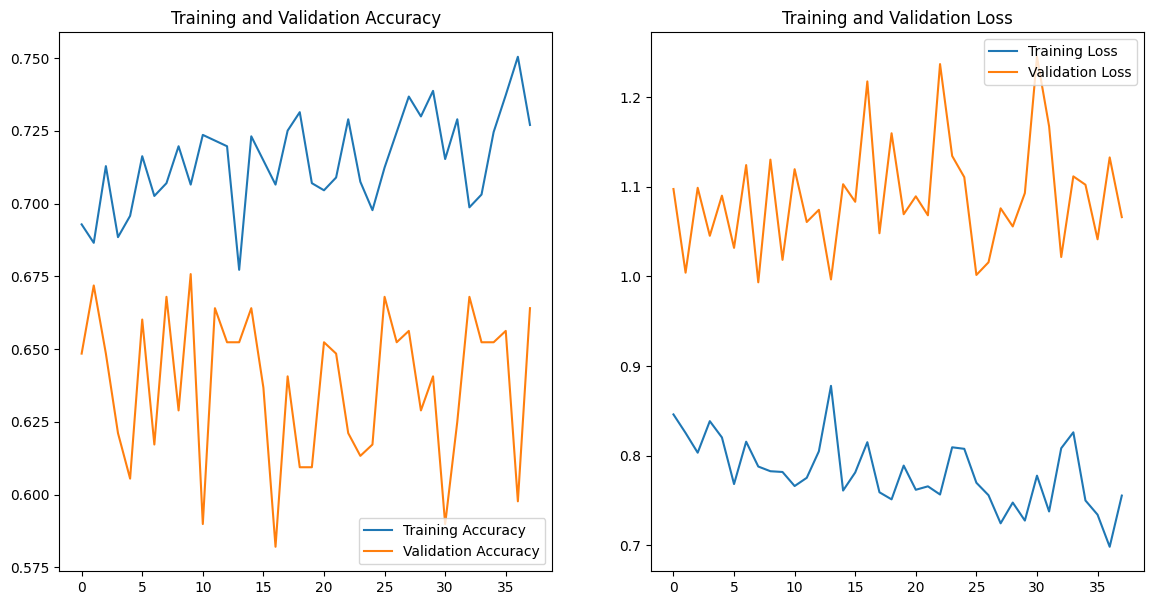

In [49]:

def plot_model_loss_curves(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(38)

  plt.figure(figsize=(14, 7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

plot_model_loss_curves(history)

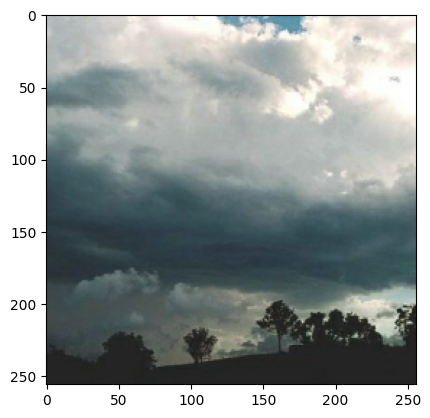

In [36]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    plt.imshow(images_batch[0].numpy().astype('uint8'))

# Prediction on a single image

first image to predict
actual label: CirroCumulus
1/1 [==============================] - 0s 148ms/step
predicted label: CirroCumulus


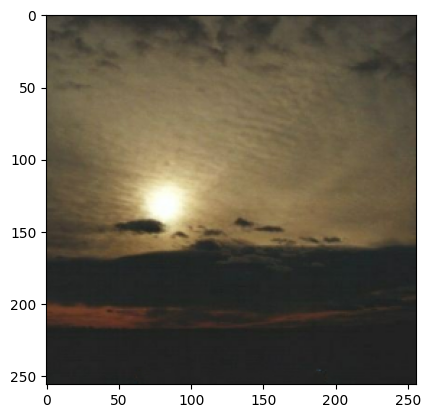

In [52]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

    plt.imshow(first_image)

# Confidence for multiple images

In [53]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


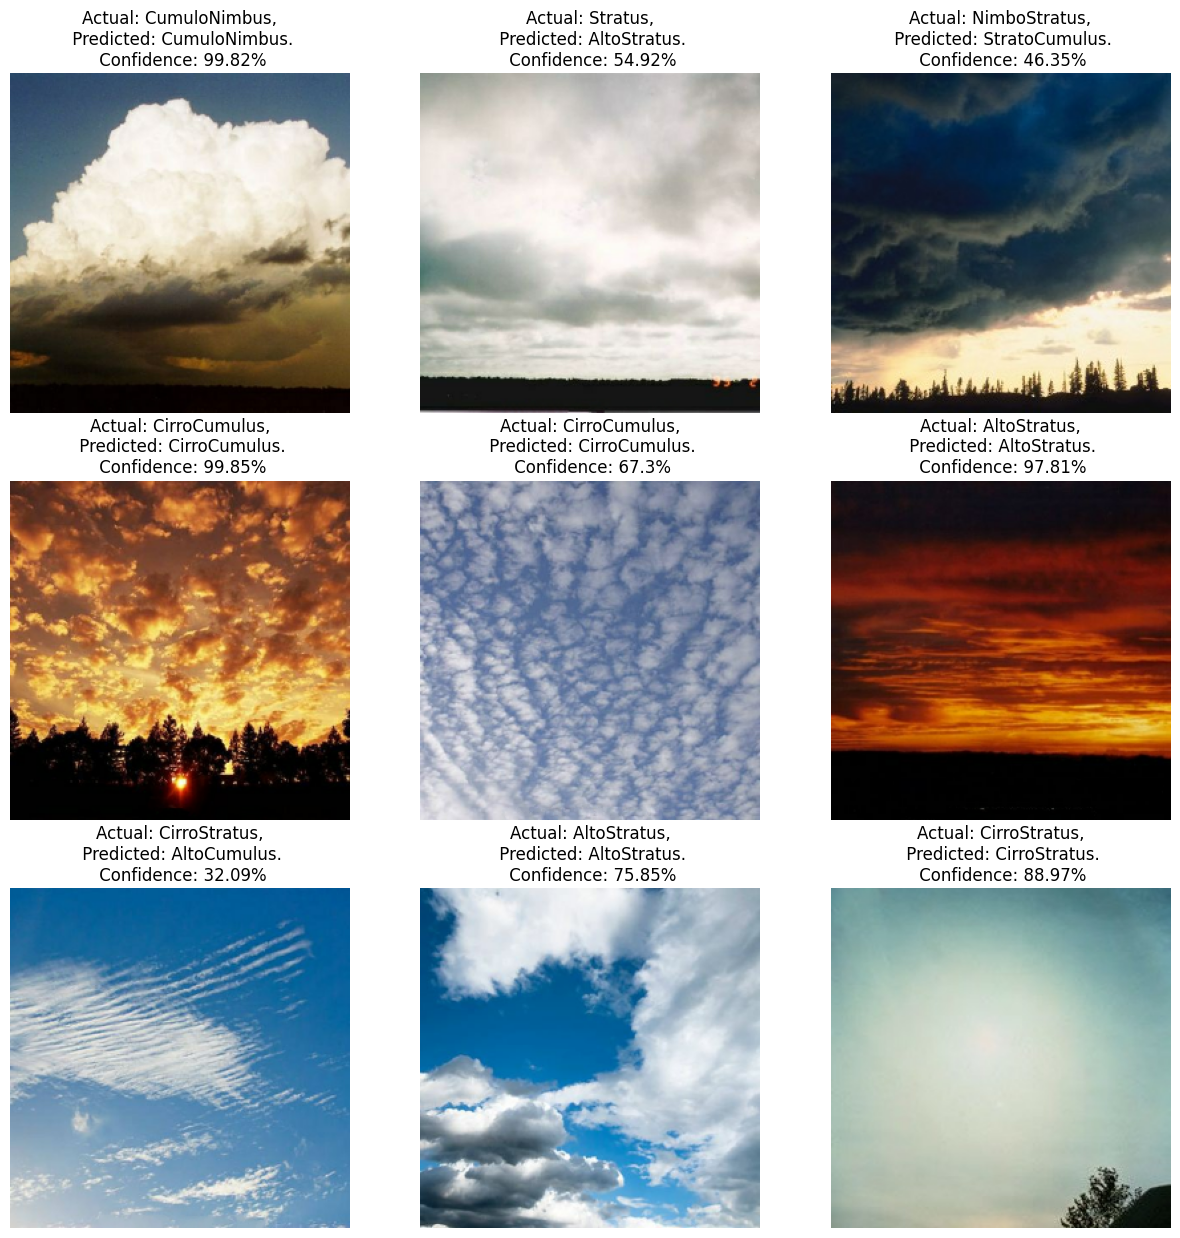

In [54]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

##Model Visualisation on Transfer Learning

In [62]:

# Evaluate on the test set
eval_result = ResNet50_model.evaluate(test_ds)

print("Test Loss:", eval_result[0])
print("Test Accuracy:", eval_result[1])

8/8 [==============================] - 3s 118ms/step - loss: 0.9449 - accuracy: 0.0703
Test Loss: 0.9449361562728882
Test Accuracy: 0.0703125


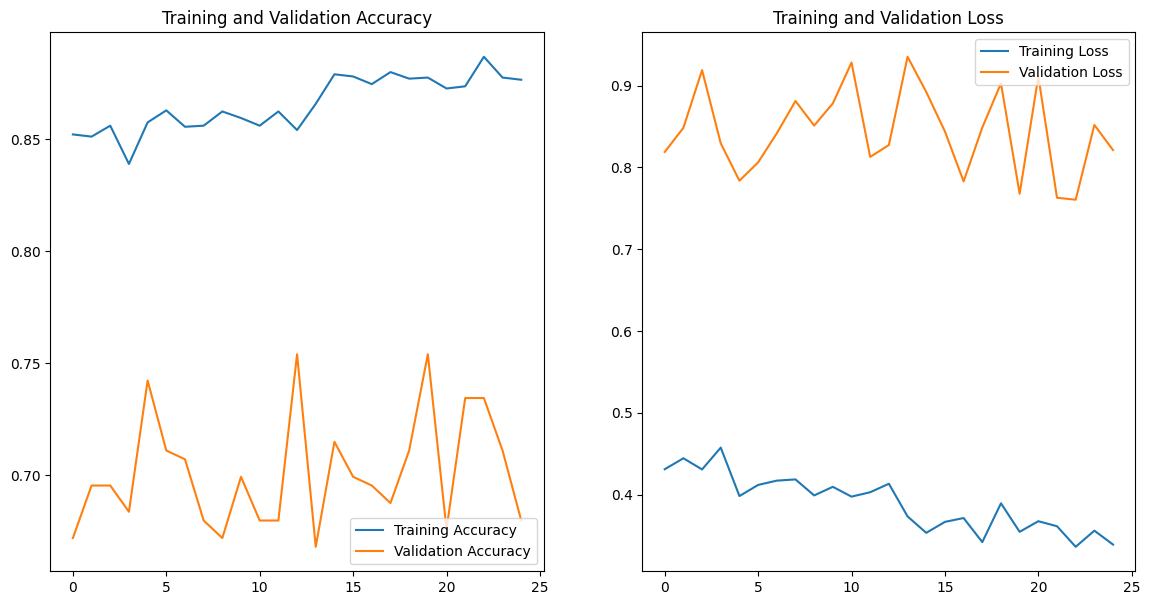

In [63]:

def plot_model_loss_curves(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(25)

  plt.figure(figsize=(14, 7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

plot_model_loss_curves(history)

##Ok!!! Now we have come to the important part which is to visualise our results
Since the dataset is in batches we are supposed to concatenate them for visualisation

In [64]:
all_predictions = []

for batch_images, _ in test_ds:
    batch_predictions = ResNet50_model.predict(batch_images)
    all_predictions.append(batch_predictions)

# Concatenate predictions from all batches
predictions = np.concatenate(all_predictions, axis=0)

1/1 [==============================] - 0s 34ms/step


In [65]:
all_true_labels = []

for _, batch_labels in test_ds:
    all_true_labels.append(batch_labels)

# Concatenate true labels from all batches
true_labels = np.concatenate(all_true_labels, axis=0)

In [66]:
from sklearn.metrics import confusion_matrix, classification_report

# Convert softmax predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Build confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print classification report
print("Classification Report:\n", classification_report(true_labels, predicted_labels))

# Plot confusion matrix using seaborn or other visualization tools

Classification Report:
               precision    recall  f1-score   support

           0       0.06      0.05      0.05        21
           1       0.00      0.00      0.00        26
           2       0.08      0.07      0.08        28
           3       0.15      0.14      0.15        28
           4       0.08      0.07      0.08        14
           5       0.06      0.06      0.06        16
           6       0.15      0.17      0.16        24
           7       0.09      0.07      0.08        15
           8       0.10      0.15      0.12        34
           9       0.17      0.19      0.18        32
          10       0.27      0.33      0.30        18

    accuracy                           0.12       256
   macro avg       0.11      0.12      0.11       256
weighted avg       0.11      0.12      0.11       256



##Confusion Matrix

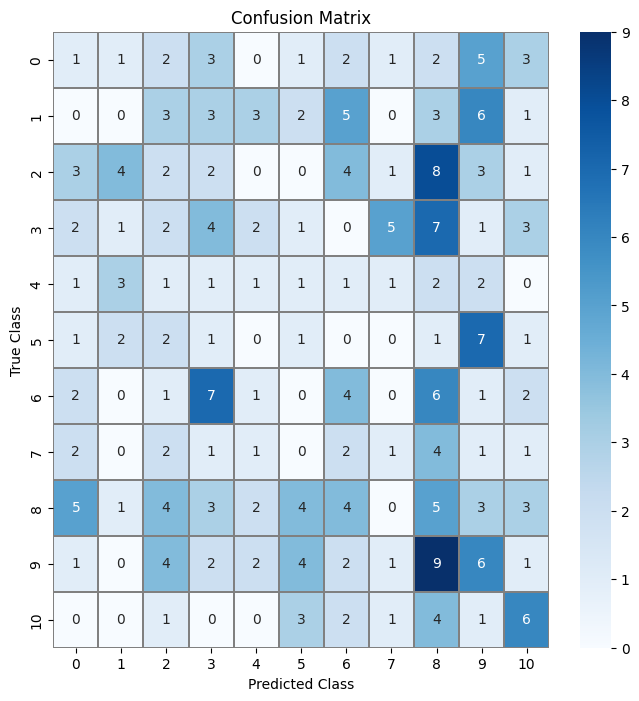

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have true_labels and predicted_labels from your model
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", linecolor="gray", linewidths=0.01, ax=ax)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

8/8 [==============================] - 1s 127ms/step


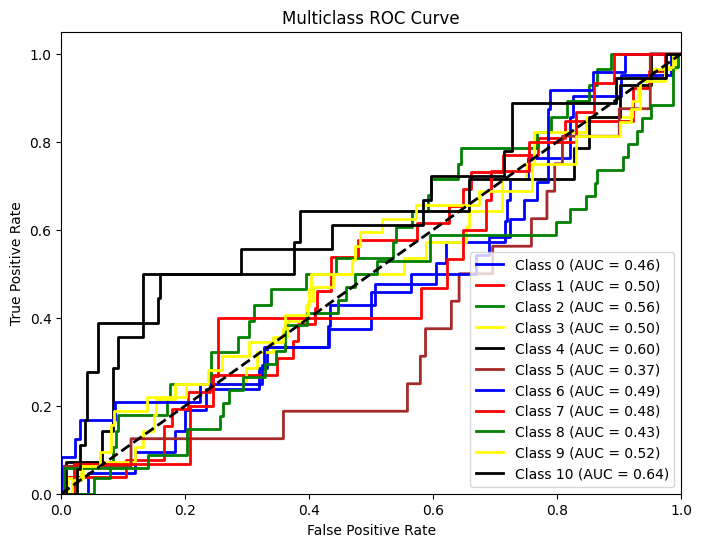

In [72]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

predictions_proba = ResNet50_model.predict(test_ds)

# Binarize the true labels
true_labels_bin = label_binarize(true_labels, classes=[0,1,2,3,4,5,6,7,8,9,10])

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = true_labels_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predictions_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))

colors = cycle(['blue', 'red', 'green', 'yellow', 'black', 'brown'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

##Confidence Threshold

In [73]:
confidence_thresholds = dict()

for i in range(n_classes):
    optimal_idx = np.argmax(tpr[i] - fpr[i])
    optimal_threshold = fpr[i][optimal_idx]
    confidence_thresholds[f'Class {i}'] = optimal_threshold

print("Confidence Thresholds:")
print(confidence_thresholds)

Confidence Thresholds:
{'Class 0': 0.825531914893617, 'Class 1': 0.43478260869565216, 'Class 2': 0.6447368421052632, 'Class 3': 0.40350877192982454, 'Class 4': 0.1322314049586777, 'Class 5': 0.004166666666666667, 'Class 6': 0.03017241379310345, 'Class 7': 0.25311203319502074, 'Class 8': 0.0045045045045045045, 'Class 9': 0.48214285714285715, 'Class 10': 0.15966386554621848}


first image to predict
actual label: CirroCumulus
1/1 [==============================] - 0s 35ms/step
predicted label: CirroStratus


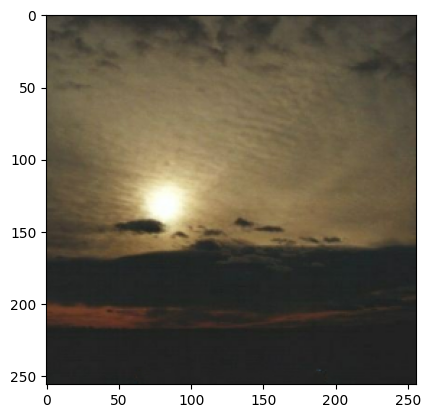

In [74]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    print("actual label:",class_names[first_label])

    batch_prediction = ResNet50_model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

    plt.imshow(first_image)

In [75]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 55ms/step


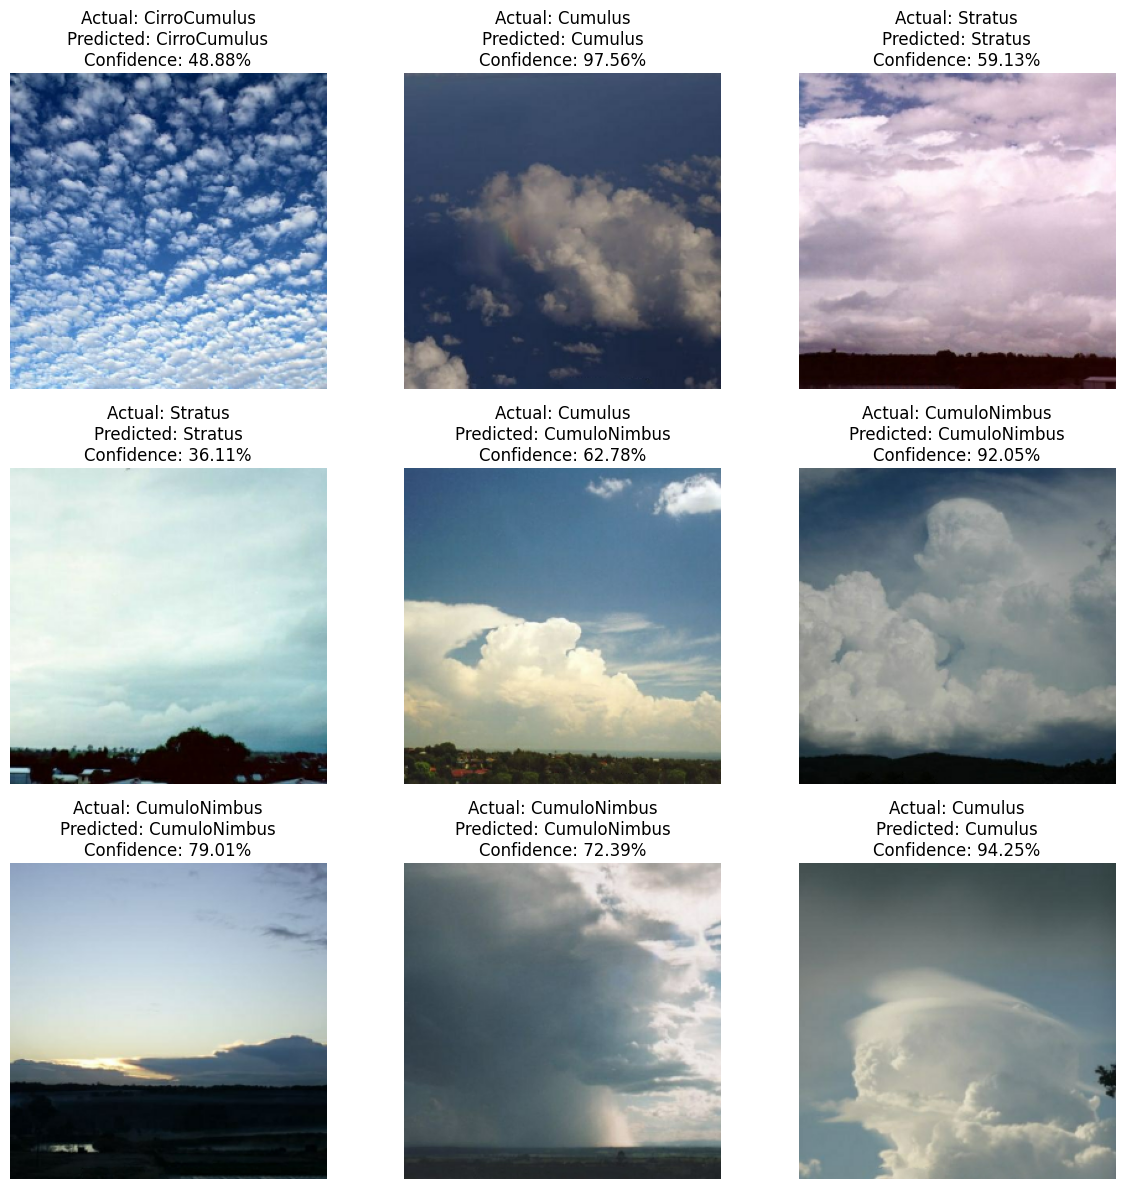

In [76]:
plt.figure(figsize=(12, 12))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(ResNet50_model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%", fontsize=12)

        plt.axis("off")

plt.tight_layout()
plt.show()

###Visualise layers and feature maps

In [77]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
model = ResNet50()

102967424/102967424 [==============================] - 1s 0us/step


In [78]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

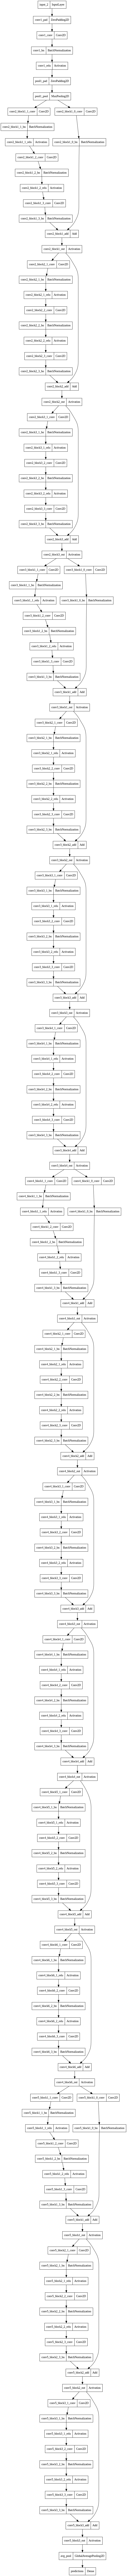

In [79]:
from keras.utils import plot_model
plot_model(model)


1/1 [==============================] - 0s 73ms/step


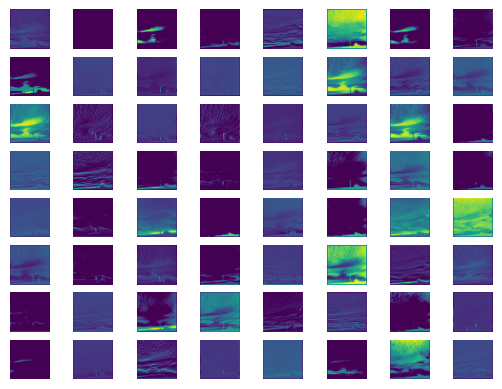

In [81]:

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input

# Function to load and preprocess the input image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Function to visualize feature maps
def visualize_feature_maps(model, layer_number, input_image):
    # Create a model that outputs the feature maps of the specified layer
    intermediate_model = Model(inputs=model.input, outputs=model.layers[layer_number].output)

    # Preprocess the input image
    img_array = load_and_preprocess_image(input_image)

    # Get the feature maps
    feature_maps = intermediate_model.predict(img_array)

    # Plot the feature maps
    square = int(np.ceil(np.sqrt(feature_maps.shape[3])))
    # fig, axes = plt.subplots(square, square, figsize=(15, 15))
    for i in range(feature_maps.shape[3]):
        plt.subplot(square, square, i + 1)
        plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.show()

# Load the pre-trained ResNet50 model
resnet_model = ResNet50(weights='imagenet')

# Specify the layer number for which you want to visualize feature maps
layer_to_visualize = 5  # You can change this to the desired layer number

# Specify the path to the input image
Altocumulus_image_path = '/content/drive/MyDrive/Cloud_Dataset/AltoCumulus/Ac-N001.jpg'

# Visualize feature maps
visualize_feature_maps(resnet_model, layer_to_visualize, Altocumulus_image_path)

# Ok!! Now model is ready for Deployment